In [1]:
import numpy as np 
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
# sns.set_palette('Set2')
import matplotlib.pyplot as plt
%matplotlib inline

# Supress Scientific notation in python
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display all columns of long dataframe
pd.set_option('display.max_columns', None)

import time
import datetime as dt

warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/nitin.garg/Dropbox/DS-stuff/Practise/Simplilearn/Data-Science-Capstone-Projects-master/Project 3/"

In [3]:
# Import datasets
train = pd.read_excel(path+'Online Retail.xlsx', parse_dates=['InvoiceDate'])

In [4]:
# Check the shape of dataset
train.shape

(541909, 8)

In [5]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


#### Duplicate records

Let's check for any duplicate record first, as those need to be removed first before any further analysis.

In [6]:
print(f'Duplicate items in train dataset is {train.duplicated().sum()}')

Duplicate items in train dataset is 5268


In [7]:
# Remove duplicate items 
train = train[~train.duplicated()]

#### Missing values

Let's check for any missing values in the dataset

In [8]:
# Define function to find missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"+"There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(train)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CustomerID,135037,25.20
Description,1454,0.30


So around **25%** of records don't have customer id value, such records are not useful for the RFM analysis. But let's check further if there are any common records which have null and non-null customer ID but same invoice number, so that we can fill the records with same customer ID and try to decrease the loss.

In [10]:
# Create a list of unique InvoiceNo with null CustomerID records
Invoice_list = train[train.CustomerID.isnull()]['InvoiceNo'].tolist()

In [11]:
# Check for the number of records with these InvoicNo
len(train[train.InvoiceNo.isin(Invoice_list)])    

135037

Here we found that the count of the Invoice with null customerID is equivalent to the number of records with missing CustomerID. Therefore we are unable to prevent the loss and have to remove all such records before any further analysis.

In [12]:
# We don't need records with Null customer id for RFM analysis so let's remove those first
rfm_train = train[train.CustomerID.notnull()].copy()

In [13]:
# Convert remaining Customer Ids to int type
rfm_train.CustomerID = (rfm_train.CustomerID).astype(int)

In [14]:
# Check the count of missing values after removing Null customer id records
missing_values_table(rfm_train) # Train

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


#### Cancelled items

Let's check those record which shows cancelled items. These records are not needed for Descriptive analysis but are accountable for the RFM analysis. So let's keep them in a different dataframe altogether.

In [15]:
# Check and remove transactions with cancelled items.
desc_df = rfm_train[~rfm_train.InvoiceNo.str.contains('C', na=False)]

In [16]:
# Let's create a feature with total cost of the transactions
desc_df['Total_cost'] = rfm_train.Quantity * rfm_train.UnitPrice

### EDA

Now let's do some Exploratory Data Analysis on the processed dataset

In [17]:
# Check the oldest and latest date in the dataset.
print(f'Oldest date is - {desc_df.InvoiceDate.min()}\n')
print(f'Latest date is - {desc_df.InvoiceDate.max()}')

Oldest date is - 2010-12-01 08:26:00

Latest date is - 2011-12-09 12:50:00


In [18]:
# Check the top ten countries in the dataset with highest transactions
desc_df.Country.value_counts(normalize=True).head(10).mul(100).round(1).astype(str) + '%'

United Kingdom    88.9%
Germany            2.3%
France             2.1%
EIRE               1.8%
Spain              0.6%
Netherlands        0.6%
Belgium            0.5%
Switzerland        0.5%
Portugal           0.4%
Australia          0.3%
Name: Country, dtype: object

Almost 90% of records belong to the sales done in UK with some it's and bits in other countries.

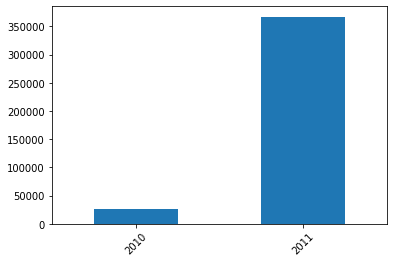

In [19]:
# Count of transactions in different years
desc_df.InvoiceDate.dt.year.value_counts(sort=False).plot(kind='bar', rot=45);

Since 2010 only includes transactions done in December, therefore it is evident that most of the records belong to 2011

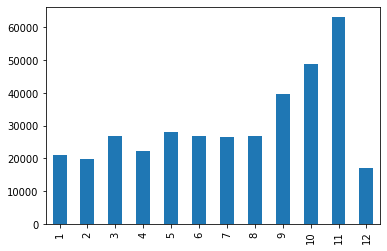

In [20]:
# Count of transactions in different months within 2011 year.
desc_df[desc_df.InvoiceDate.dt.year==2011].InvoiceDate.dt.month.value_counts(sort=False).plot(kind='bar');

An increasing pattern can be observed month by month wise with a sharp decline in the month of December. That is evident because only first 8-9 days of December 2011 month is available in the dataset i.e. around 70% of the month transactions are not considered. Due to this fact, sales figure looks legitimate.

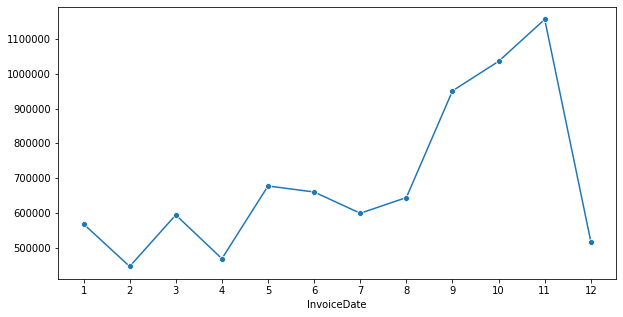

In [21]:
# Let's visualize the top grossing months
monthly_gross = desc_df[desc_df.InvoiceDate.dt.year==2011].groupby(desc_df.InvoiceDate.dt.month).Total_cost.sum()
plt.figure(figsize=(10,5))
sns.lineplot(y=monthly_gross.values,x=monthly_gross.index, marker='o');
plt.xticks(range(1,13))
plt.show();

A similar pattern is also observed in total gross each month as per the count of transactions in each month

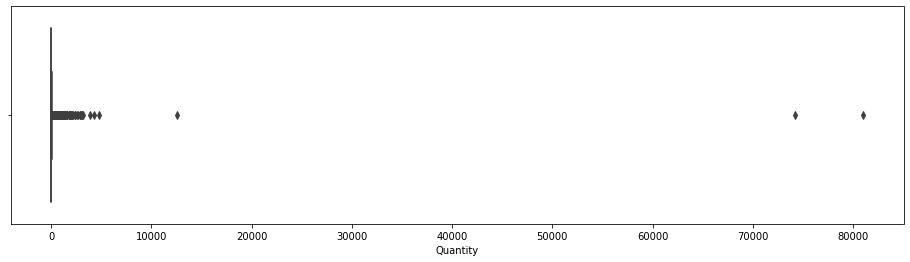

In [22]:
# Boxplot to visualize the Quantity distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='Quantity', data=desc_df, orient='h');

This shows that Quantity data is highly skewed towards lower quantity values with some outliers. May be data entry error or might be genuine order

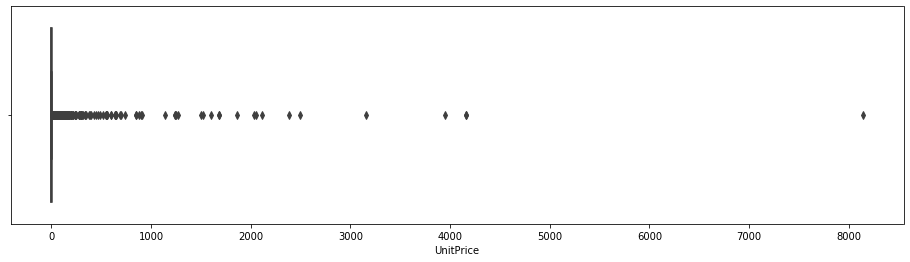

In [23]:
# Let's visualize the Unit price distribution
plt.figure(figsize=(16,4))
sns.boxplot(y='UnitPrice', data=desc_df, orient='h');

Similarly, Price of unit data shows heavy skewed distribution towards lower values of unit price.

In [24]:
desc_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


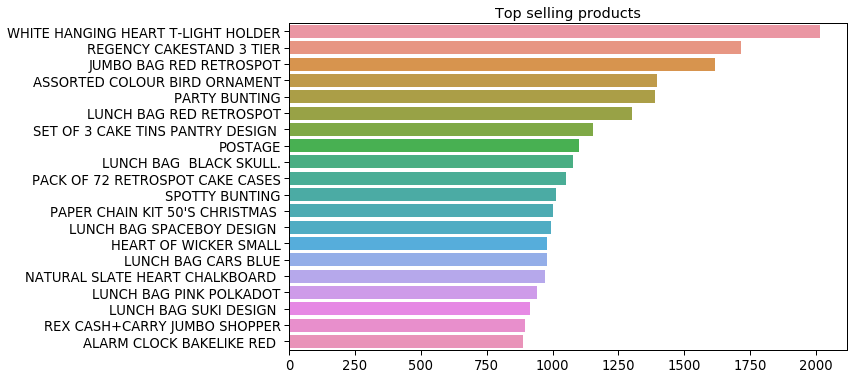

In [25]:
# Let's visualize some top products from the whole range.
top_products = desc_df['Description'].value_counts()[:20]
plt.figure(figsize=(10,6))
sns.set_context("paper", font_scale=1.5)
sns.barplot(y = top_products.index,
            x = top_products.values)
plt.title("Top selling products")
plt.show();

**Here is the Tableau interactive dashboard for Data analysis of the online store. Please try to explore by clicking on individual attribute in the graphs under the dashboard** 

**NOTE**: please disable any ad-blocker if the tableau visual is not visible

In [99]:
%%html
<div class='tableauPlaceholder' id='viz1574249006038' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mu&#47;Multinationonlineretailstore&#47;OnlineStoreDashboard&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Multinationonlineretailstore&#47;OnlineStoreDashboard' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Mu&#47;Multinationonlineretailstore&#47;OnlineStoreDashboard&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1574249006038');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1100px';vizElement.style.height='877px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1100px';vizElement.style.height='877px';} else { vizElement.style.width='100%';vizElement.style.height='1777px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Cohort Analysis

A cohort is a group of subjects who share a defining characteristic. We can observe how a cohort behaves across time and compare it to other cohorts. 

#### Types of cohorts:

- **Time Cohorts** are customers who signed up for a product or service during a particular time frame. Analyzing these cohorts shows the customers’ behavior depending on the time they started using the company’s products or services. The time may be monthly or quarterly even daily.
- **Behavior cohorts** are customers who purchased a product or subscribed to a service in the past. It groups customers by the type of product or service they signed up. Customers who signed up for basic level services might have different needs than those who signed up for advanced services. Understaning the needs of the various cohorts can help a company design custom-made services or products for particular segments.
- **Size cohorts** refer to the various sizes of customers who purchase company’s products or services. This categorization can be based on the amount of spending in some periodic time after acquisition or the product type that the customer spent most of their order amount in some period of time.

***For cohort analysis, there are a few labels that we have to create:***

- **Invoice period** - A string representation of the year and month of a single transaction/invoice.
- **Cohort group:**- A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
- **Cohort period/Index**-  A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [27]:
# Create a copy of rfm_train dataframe for cohort analysis
cohort = rfm_train.copy()

### Assign monthly acquisition cohort
Defining a cohort is the first step to cohort analysis. We will now create monthly cohorts based on the month each customer has made their first transaction.

In [28]:
# Define a function that will parse the date
def get_month(x):
    return dt.datetime(x.year,x.month,1) 

# Create InvoiceMonth column
cohort['InvoiceMonth'] = cohort['InvoiceDate'].apply(get_month) 

# Group by CustomerID and select the InvoiceMonth value
grouping = cohort.groupby('CustomerID')['InvoiceMonth'] 

# Assign a minimum InvoiceMonth value to the dataset
cohort['CohortMonth'] = grouping.transform('min')

### Calculate time offset in months
Calculating time offset for each transaction allows you to report the metrics for each cohort in a comparable fashion.

First, we will create some variables that capture the integer value of years and months for Invoice and Cohort Date using the get_date_int() function

In [29]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

In [30]:
# Get the integers for date parts from the `InvoiceMonth` column
invoice_year, invoice_month = get_date_int(cohort,'InvoiceMonth')

# Get the integers for date parts from the `CohortMonth` column
cohort_year, cohort_month = get_date_int(cohort,'CohortMonth')

In [31]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Extract the difference in months from all previous values
cohort['CohortIndex'] = years_diff * 12 + months_diff + 1

In [32]:
cohort.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010-12-01,2010-12-01,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010-12-01,2010-12-01,1


### Calculate retention rate

Customer retention is a very useful metric to understand how many of all the customers are still active. It gives you the percentage of active customers compared to the total number of customers


In [33]:
grouping = cohort.groupby(['CohortMonth', 'CohortIndex'])

In [34]:
# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)*100

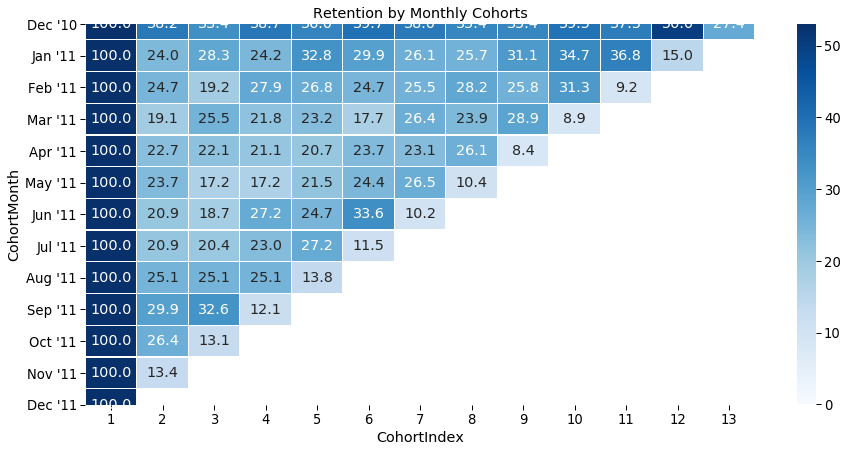

In [35]:
month_list = ["Dec '10", "Jan '11", "Feb '11", "Mar '11", "Apr '11",\
              "May '11", "Jun '11", "Jul '11", "Aug '11", "Sep '11", \
              "Oct '11", "Nov '11", "Dec '11"]

# Initialize inches plot figure
plt.figure(figsize=(15,7))

# Add a title
plt.title('Retention by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data=retention,
            annot = True,
            cmap = "Blues",
            vmin = 0.0,
#             vmax = 0.5,
            vmax = list(retention.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)

plt.show();

### Calculate average price per cohort

Now we will calculate the average price metric and analyze if there are any differences in shopping patterns across time and across cohorts.

In [36]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = cohort.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
average_price.round(1)
average_price.index = average_price.index.date

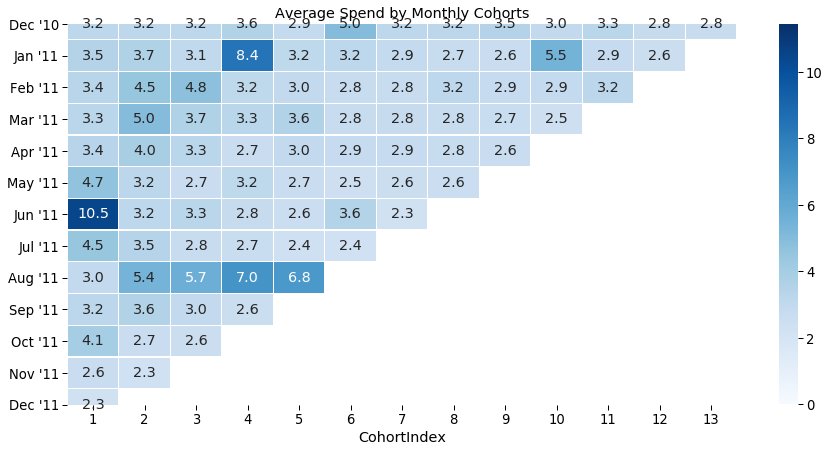

In [37]:
# Initialize plot figure
plt.figure(figsize=(15, 7))

# Add a title
plt.title('Average Spend by Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_price,
            annot=True,
            vmin = 0.0,
#             vmax =20,
            cmap='Blues',
            vmax = list(average_price.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

### Calculate average quantity per cohort

Now we will calculate the average quantity metric and analyze if there are any differences in shopping patterns across time and across cohorts.

In [38]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = cohort.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the Quantity column
cohort_data = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
# average_quantity.round(1)
# average_quantity.index = average_quantity.index.date

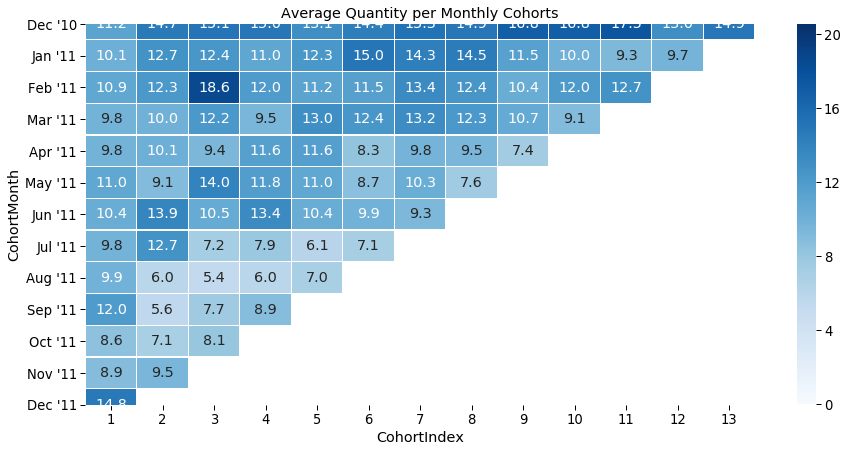

In [39]:
# Initialize plot figure
plt.figure(figsize=(15, 7))

# Add a title
plt.title('Average Quantity per Monthly Cohorts')

# Create the heatmap
sns.heatmap(data = average_quantity,
            annot=True,
            vmin = 0.0,
            cmap='Blues',
            vmax = list(average_quantity.max().sort_values(ascending = False))[1]+3,
            fmt = '.1f',
            linewidth = 0.3,
            yticklabels=month_list)
plt.show();

## RFM Analysis
**RFM** analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

- **Recency** (R): Time since last purchase
- **Frequency** (F): Total number of purchases 
- **Monetary** (M): Total purchase value

#### Benefits of RFM analysis

- Increased customer retention
- Increased response rate
- Increased conversion rate
- Increased revenue

To perform RFM analysis, we divide customers into four equal groups according to the distribution of values for recency, frequency, and monetary value. Four equal groups across three variables create 64 (4x4x4) different customer segments, which is a manageable number.

#### For example, let’s look at a customer who:

- is within the group who purchased most recently (R=4),
- is within the group who purchased most quantity (F=4),
- is within the group who spent the most (M=4)

This customer belongs to RFM segment **4-4-4 (Best Customers)**, (R=4, F=4, M=4)

Below is a table with key RFM segments:

<img src="https://i.imgur.com/TUCtmPT.png" style="float: left;">

### Recency
Recency is about when was the last order of a customer. It means the number of days since a customer made the last purchase. If it’s a case for a website or an app, this could be interpreted as the last visit day or the last login time.

In [40]:
#last date available in our dataset
rfm_train['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [41]:
# Lets set this date as the today's date for further analysis
current_date = dt.date(2011,12,9)

In [42]:
# Lets create a date column for date values only
rfm_train['Purchase_Date'] = rfm_train.InvoiceDate.dt.date

In [43]:
recency = rfm_train.groupby('CustomerID')['Purchase_Date'].max().reset_index()

In [44]:
# Create a separate column for this date.
recency = recency.assign(Current_Date = current_date)

In [45]:
# Compute the number of days since last purchase
recency['Recency'] = recency.Purchase_Date.apply(lambda x: (current_date - x).days)

In [46]:
recency.head()

,CustomerID,Purchase_Date,Current_Date,Recency
0,12346,2011-01-18,2011-12-09,325
1,12347,2011-12-07,2011-12-09,2
2,12348,2011-09-25,2011-12-09,75
3,12349,2011-11-21,2011-12-09,18
4,12350,2011-02-02,2011-12-09,310


In [47]:
# Drop the irrelevant Date columns
recency.drop(['Purchase_Date','Current_Date'], axis=1, inplace=True)

### Frequency
Frequency is about the number of purchase in a given period. It could be 3 months, 6 months or 1 year. So we can understand this value as for how often or how many a customer used the product of a company. The bigger the value is, the more engaged the customers are. Could we say them as our VIP? Not necessary. Cause we also have to think about how much they actually paid for each purchase, which means monetary value

In [48]:
frequency = rfm_train.groupby('CustomerID').InvoiceNo.nunique().reset_index().rename(columns={'InvoiceNo':'Frequency'})

In [49]:
frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


### Monetary
Monetary is the total amount of money a customer spent in that given period. Therefore big spenders will be differentiated with other customers such as MVP or VIP.

In [50]:
# Create a separate column for Total Cost of Unit purchased
rfm_train['Total_cost'] = rfm_train.Quantity * rfm_train.UnitPrice

In [51]:
monetary = rfm_train.groupby('CustomerID').Total_cost.sum().reset_index().rename(columns={'Total_cost':'Monetary'})

In [52]:
monetary.head()

,CustomerID,Monetary
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


Now Combine all three to form an aggregated RFM Table

In [53]:
temp_ = recency.merge(frequency, on='CustomerID')
rfm_table = temp_.merge(monetary, on='CustomerID')

In [54]:
rfm_table.set_index('CustomerID',inplace=True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,18,1,1757.55
12350,310,1,334.40


### RFM Table integrity Check

Let's check whether the RFM table attributes are in conjunction with the original values

In [55]:
# Fetch the records corresponding to the first customer id in above table
rfm_train[rfm_train.CustomerID == rfm_table.index[0]]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Purchase_Date,Total_cost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,2011-01-18,77183.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,2011-01-18,-77183.60


In [56]:
# Check if the number difference of days from the purchase date in original record is same as shown in rfm table.
(current_date - rfm_train[rfm_train.CustomerID == rfm_table.index[0]].iloc[0].Purchase_Date).days == rfm_table.iloc[0,0]

True

### Customer segments with RFM Model
The simplest way to create customers segments from RFM Model is to use Quantiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [57]:
# RFM Quantiles
quantiles = rfm_table.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,16.00,1.00,291.79
0.50,50.00,3.00,644.07
0.75,143.00,5.00,1608.34


In [58]:
# Let's convert quartile information into a dictionary so that cutoffs can be picked up.
quantiles=quantiles.to_dict()
quantiles

{'Recency': {0.25: 16.0, 0.5: 50.0, 0.75: 143.0},
 'Frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 5.0},
 'Monetary': {0.25: 291.79499999999996,
  0.5: 644.0700000000002,
  0.75: 1608.335}}

### Creation of RFM Segments
We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good

In [59]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quantiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [60]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quantiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [61]:
rfm_segment = rfm_table.copy()
rfm_segment['R_Quartile'] = rfm_segment['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segment['F_Quartile'] = rfm_segment['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segment['M_Quartile'] = rfm_segment['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [62]:
rfm_segment.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346,325,2,0.00,1,2,1
12347,2,7,4310.00,4,4,4
12348,75,4,1797.24,2,3,4
12349,18,1,1757.55,3,1,4
12350,310,1,334.40,1,1,2


For analysis it is critical to combine the scores to create a single score. There are few approaches. One approach is to just concatenate the scores to create a 3 digit number between 111 and 444. Here the drawback is too many categories (4x4x4).

In [63]:
rfm_segment['RFMScore'] = rfm_segment.R_Quartile.map(str) \
                            + rfm_segment.F_Quartile.map(str) \
                            + rfm_segment.M_Quartile.map(str)
rfm_segment.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346,325,2,0.00,1,2,1,121
12347,2,7,4310.00,4,4,4,444
12348,75,4,1797.24,2,3,4,234
12349,18,1,1757.55,3,1,4,314
12350,310,1,334.40,1,1,2,112


- **Best Recency score** = 4 (most recently purchase) 
- **Best Frequency score** = 4 (most frequently purchase)
- **Best Monetary score** = 4 (who spent the most)

### RFM Segment allocation

Lets define the customers segment best to our knowledge basis RFM score and assign them to each customer respectively.

In [64]:
# Reset the index to create a customer_ID column
rfm_segment.reset_index(inplace=True)

In [65]:
# Create a dictionary for each segment to map them against each customer
segment_dict = {
    'Best Customers':'444',      # Highest frequency as well as monetary value with least recency
    'Loyal Customers':'344',     # High frequency as well as monetary value with good recency
    'Big Spenders':'334',        # High monetary value but good recency and frequency values
    'Almost Lost':'244',         # Customer's shopping less often now who used to shop a lot
    'Lost Customers':'144',      # Customer's shopped long ago who used to shop a lot.
    'Recent Customers':'443',    # Customer's who recently started shopping a lot but with less monetary value
    'Lost Cheap Customers':'122' # Customer's shopped long ago but with less frequency and monetary value
}

In [66]:
# Swap the key and value of dictionary
dict_segment = dict(zip(segment_dict.values(),segment_dict.keys()))

In [67]:
# Allocate segments to each customer as per the RFM score mapping
rfm_segment['Segment'] = rfm_segment.RFMScore.map(lambda x: dict_segment.get(x))

In [68]:
# Allocate all remaining customers to others segment category
rfm_segment.Segment.fillna('others', inplace=True)

In [69]:
rfm_segment.sample(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
2156,15261,135,1,254.82,2,1,1,211,others
1363,14180,10,31,4640.77,4,4,4,444,Best Customers
621,13157,49,5,1721.57,3,3,4,334,Big Spenders
3786,17495,7,2,497.56,4,2,2,422,others
4115,17935,138,2,145.79,2,2,1,221,others
4214,18077,8,11,2584.41,4,4,4,444,Best Customers
4250,18123,24,2,574.44,3,2,2,322,others
1127,13860,1,6,1240.00,4,4,3,443,Recent Customers
718,13292,38,2,578.94,3,2,2,322,others
936,13591,64,3,1117.13,2,2,3,223,others


**Here is the Tableau interactive dashboard for Data analysis of the online store. Please try to explore by clicking on individual attribute in the graphs under the dashboard** 

**NOTE**: please disable any ad-blocker if the tableau visual is not visible

In [100]:
%%html
<div class='tableauPlaceholder' id='viz1574249157493' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;RF&#47;RFM_Analysis_15741611609370&#47;RFMAnalysis&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='RFM_Analysis_15741611609370&#47;RFMAnalysis' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;RF&#47;RFM_Analysis_15741611609370&#47;RFMAnalysis&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1574249157493');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='1100px';vizElement.style.height='877px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='1100px';vizElement.style.height='877px';} else { vizElement.style.width='100%';vizElement.style.height='1777px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

#### Let's visualize different customer segments records in general to answers these questions for the retail business.

- Who are my best customers?
- Who are the biggest spenders?
- Which customers are at the verge of churning?
- Who are lost customers that you don’t need to pay much attention to?
- Who are your loyal customers?
- Which customers you must retain?
- Who has the potential to be converted in more profitable customers?
- Which group of customers is most likely to respond to your current campaign?

In [71]:
# Best Customers who's recency, frequency as well as monetary attribute is highest.
rfm_segment[rfm_segment.RFMScore=='444'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
1703,14646,1,77,279489.02,4,4,4,444,Best Customers
4233,18102,0,62,256438.49,4,4,4,444,Best Customers
3758,17450,8,55,187322.17,4,4,4,444,Best Customers
1895,14911,1,248,132458.73,4,4,4,444,Best Customers
1345,14156,9,66,113214.59,4,4,4,444,Best Customers


In [72]:
# Biggest spenders
rfm_segment[rfm_segment.RFMScore=='334'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
2794,16126,29,4,6287.77,3,3,4,334,Big Spenders
737,13316,37,5,5570.69,3,3,4,334,Big Spenders
2923,16303,25,4,5305.83,3,3,4,334,Big Spenders
2897,16258,45,5,5203.51,3,3,4,334,Big Spenders
70,12432,42,5,5059.32,3,3,4,334,Big Spenders


In [73]:
# Almost Lost i.e. who's recency value is low
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
464,12939,64,8,11581.80,2,4,4,244,Almost Lost
50,12409,78,7,11056.93,2,4,4,244,Almost Lost
2836,16180,100,10,10217.48,2,4,4,244,Almost Lost
328,12744,51,10,9120.39,2,4,4,244,Almost Lost
3248,16745,86,18,7157.10,2,4,4,244,Almost Lost


In [74]:
# Lost customers that don't needs attention who's recency, frequency as well as monetary values are low
rfm_segment[rfm_segment.RFMScore=='122'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
1578,14481,164,2,636.51,1,2,2,122,Lost Cheap Customers
2246,15384,169,3,635.76,1,2,2,122,Lost Cheap Customers
1230,14000,206,2,633.71,1,2,2,122,Lost Cheap Customers
1985,15045,151,3,633.66,1,2,2,122,Lost Cheap Customers
1391,14220,247,2,632.40,1,2,2,122,Lost Cheap Customers


In [75]:
# loyal customers who's purchase frequency is high
rfm_segment[rfm_segment.RFMScore=='344'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
55,12415,24,26,123725.45,3,4,4,344,Loyal Customers
2722,16029,38,76,53168.69,3,4,4,344,Loyal Customers
3014,16422,17,75,33805.69,3,4,4,344,Loyal Customers
458,12931,21,20,33462.81,3,4,4,344,Loyal Customers
1728,14680,25,23,26932.34,3,4,4,344,Loyal Customers


In [76]:
# customers that you must retain are those whose monetary and frequency was high but recency reduced quite a lot recently
rfm_segment[rfm_segment.RFMScore=='244'].sort_values('Monetary', ascending=False).head()

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment
464,12939,64,8,11581.80,2,4,4,244,Almost Lost
50,12409,78,7,11056.93,2,4,4,244,Almost Lost
2836,16180,100,10,10217.48,2,4,4,244,Almost Lost
328,12744,51,10,9120.39,2,4,4,244,Almost Lost
3248,16745,86,18,7157.10,2,4,4,244,Almost Lost


## K-Means Clustering
We will now cluster our customers with K-Means! So let's visualize the data distribution in RFM table

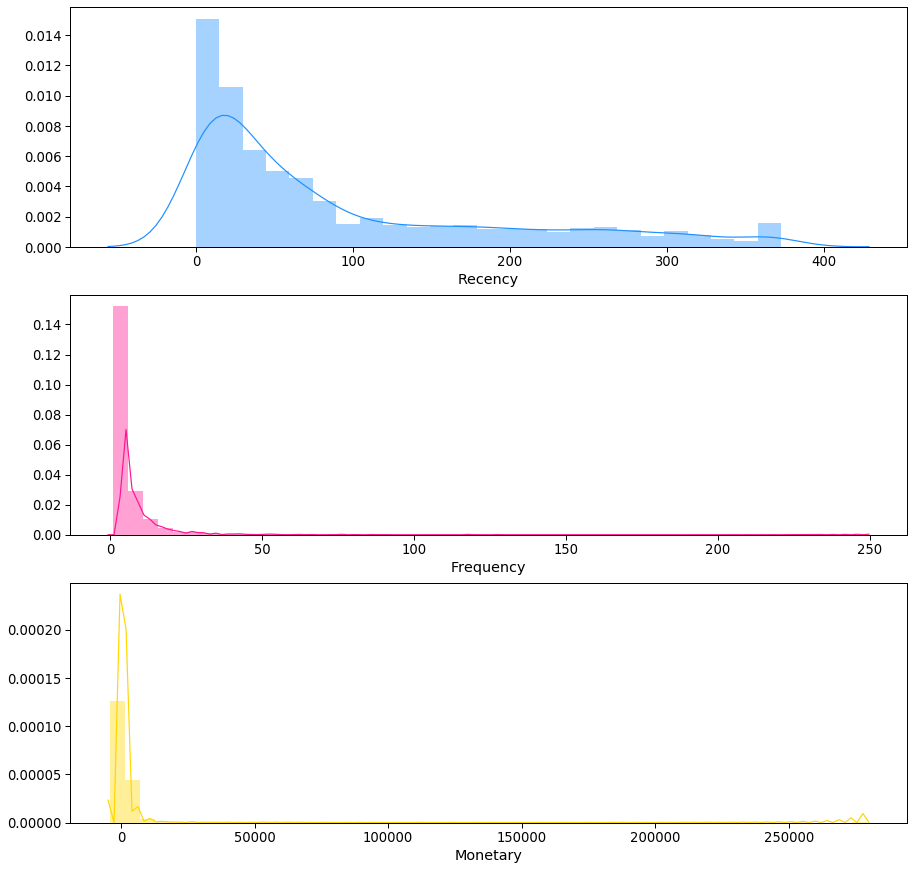

In [77]:
# plot
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(rfm_table.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(rfm_table.Frequency , color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(rfm_table.Monetary , color="gold", ax=axes[2], axlabel='Monetary')
# plt.xlim(50,75);
plt.show();

Here we can observe that the data is highly skewed. So we have to transform and scale the data first because K-Means assumes that the variables should have a symmetric distributions(not skewed) and they should have same average values as well as same variance. 

In [78]:
# Let's describe the table to see if there are any negative values
rfm_table.describe()

,Recency,Frequency,Monetary
count,4372.00,4372.00,4372.00
mean,91.58,5.08,1893.53
std,100.77,9.34,8218.70
min,0.00,1.00,-4287.63
25%,16.00,1.00,291.79
50%,50.00,3.00,644.07
75%,143.00,5.00,1608.34
max,373.00,248.00,279489.02


We can observe that Monetary contains negative values. So first we need to make sure that minimum range of value starts from 1 otherwise log transformation may lead to errors in graph plotting as well as K-Means clustering. After that we will utilize log transformation and scaling to make data available for for K-Means clustering.

In [79]:
# Create a copy of rfm table
rfm_table_scaled = rfm_table.copy()

# Shift all values in the column by adding absolute of minimum value to each value, thereby making each value positive.
rfm_table_scaled.Monetary = rfm_table_scaled.Monetary + abs(rfm_table_scaled.Monetary.min()) + 1
rfm_table_scaled.Recency = rfm_table_scaled.Recency + abs(rfm_table_scaled.Recency.min()) + 1

# Check the summary of new values
rfm_table_scaled.describe()

,Recency,Frequency,Monetary
count,4372.00,4372.00,4372.00
mean,92.58,5.08,6182.16
std,100.77,9.34,8218.70
min,1.00,1.00,1.00
25%,17.00,1.00,4580.43
50%,51.00,3.00,4932.70
75%,144.00,5.00,5896.97
max,374.00,248.00,283777.65


In [80]:
# Transform the data before K-Means clustering
from sklearn.preprocessing import StandardScaler

# Taking log first because normalization forces data for negative values
log_df = np.log(rfm_table_scaled)

# Normalize the data for uniform averages and means in the distribution.
scaler = StandardScaler()
normal_df = scaler.fit_transform(log_df)
normal_df = pd.DataFrame(data=normal_df, index=rfm_table.index, columns=rfm_table.columns)

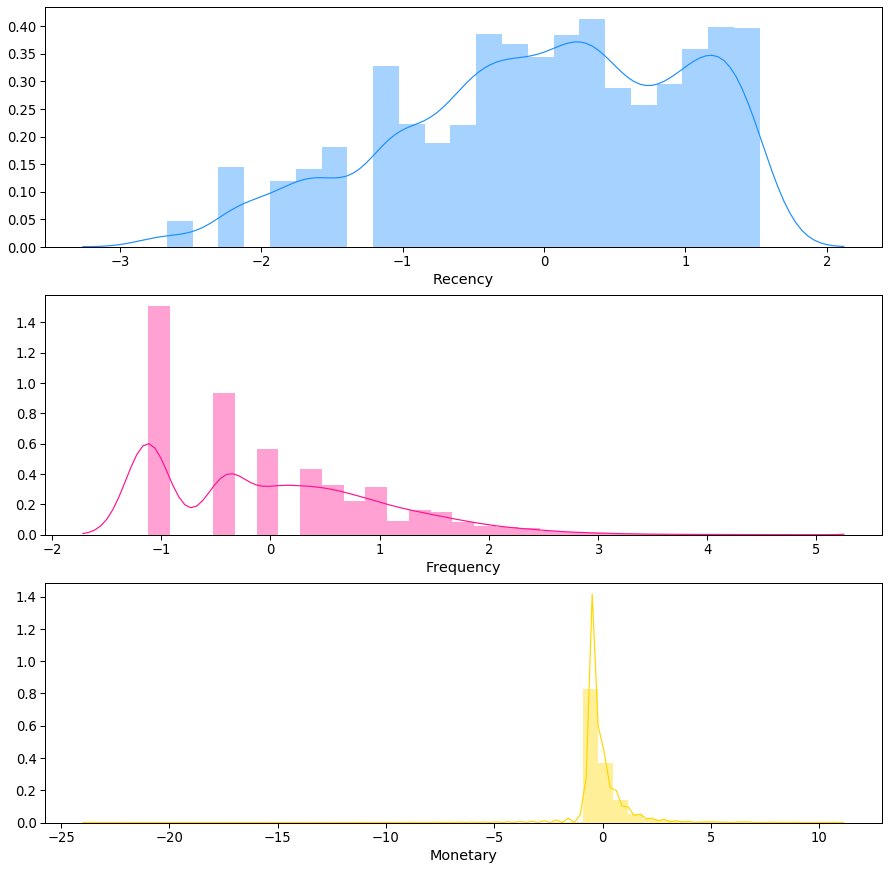

In [81]:
# plot again on the transformed RFM data
fig, axes = plt.subplots(3, 1, figsize=(15, 15))
sns.distplot(normal_df.Recency , color="dodgerblue", ax=axes[0], axlabel='Recency')
sns.distplot(normal_df.Frequency , color="deeppink", ax=axes[1], axlabel='Frequency')
sns.distplot(normal_df.Monetary , color="gold", ax=axes[2], axlabel='Monetary')
plt.show();

We can observe that the means & averages are approximately uniformed now in each distribution. Now the data is apt for unsupervised algo i.e. K-Means. Lets try to find number of appropriate clusters to divide customers as per there spending pattern with **elbow** method first

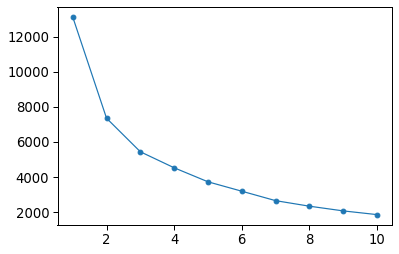

In [82]:
# find WCSS
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++')
    kmeans.fit(normal_df)
    wcss.append(kmeans.inertia_)

# plot elbow graph
plt.plot(range(1,11),wcss,marker='o');

From the elbow graph, it seems that good number of cluster would be either 2 or 3 as after that, its a smooth curve i.e. no change of orientation. but to overcome that confusion, we will use **silhouette score** method to find the optimum number of clusters because it is often much better in figuring out the number of valid clusters than the elbow method

Silhouette score for number of cluster(s) 2: 0.4405297656150766
Silhouette score for number of cluster(s) 3: 0.39677649451050456
Silhouette score for number of cluster(s) 4: 0.338013340102464
Silhouette score for number of cluster(s) 5: 0.3626494830847667
Silhouette score for number of cluster(s) 6: 0.36490903870225994
Silhouette score for number of cluster(s) 7: 0.35470438765991774
Silhouette score for number of cluster(s) 8: 0.34664985914118013
Silhouette score for number of cluster(s) 9: 0.3439470526219597
Silhouette score for number of cluster(s) 10: 0.3526441041738994
Silhouette score for number of cluster(s) 11: 0.3618099356284099


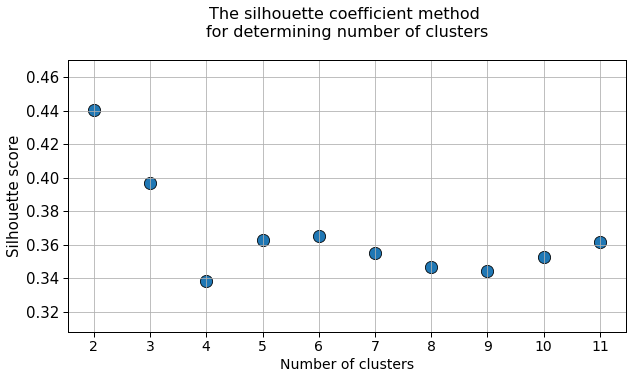

In [83]:
from sklearn.metrics import silhouette_score
wcss_silhouette = []
for i in range(2,12):
    km = KMeans(n_clusters=i, random_state=0,init='k-means++').fit(normal_df)
    preds = km.predict(normal_df)    
    silhouette = silhouette_score(normal_df,preds)
    wcss_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))

plt.figure(figsize=(10,5))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,12)],y=wcss_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,12)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Here we can clearly see that optimum number of cluster should be 4 not 2 or 3. Because that is the only point after which the mean cluster distance looks to be plateaued after a steep downfall. So we will assume the 4 number of clusters as best for grouping of customer segments.

Now let's apply K-Means on 4 clusters to segregate the customer base.

In [84]:
kmeans = KMeans(n_clusters=4, random_state=1, init='k-means++')
kmeans.fit(normal_df)
cluster_labels = kmeans.labels_

In [85]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=1, tol=0.0001, verbose=0)

In [86]:
print(f"Shape of cluster label array is {cluster_labels.shape}")
print(f"Shape of RFM segment dataframe is {rfm_segment.shape}")

Shape of cluster label array is (4372,)
Shape of RFM segment dataframe is (4372, 9)


In [87]:
# Assign the clusters as column to each customer
Cluster_table = rfm_segment.assign(Cluster = cluster_labels)

In [88]:
# Check counts of records assigned to different clusters
Cluster_table.Cluster.value_counts()

0    1784
3    1512
2     952
1     124
Name: Cluster, dtype: int64

Here we see that most of the customers belong to 0 and 3 cluster, whereas very less number of customers assigned to 1 cluster, may be possible that those are some of the best customers out of the pool or worst customer, lets checkout the pattern

In [89]:
Cluster_table.sample(10)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
3301,16809,23,6,912.74,3,4,3,343,others,3
2721,16027,91,7,852.12,2,4,3,243,others,3
3968,17730,3,15,5288.83,4,4,4,444,Best Customers,2
998,13684,285,2,62.13,1,2,1,121,others,0
1241,14016,154,5,4328.46,1,3,4,134,others,2
4034,17830,1,3,398.70,4,2,2,422,others,3
3950,17706,4,22,10097.37,4,4,4,444,Best Customers,1
3545,17153,24,1,213.78,3,1,1,311,others,3
3180,16654,141,5,594.97,2,3,2,232,others,0
830,13450,26,6,2043.72,3,4,4,344,Loyal Customers,2


Here we can observe that RFM score is very low for customers in 0 & 3 cluster. Comparetivey, customers in 1&2 clusters have high RFM scores along with above average Recency and frequency values. 

Let's checkout customers in each cluster more closely

In [90]:
Cluster_table[Cluster_table.Cluster == 3].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
1283,14073,21,2,139.54,3,2,1,321,others,3
1965,15022,11,4,852.39,4,3,3,433,others,3
1449,14300,18,1,43.20,3,1,1,311,others,3
1220,13986,17,1,320.46,3,1,2,312,others,3
3972,17734,53,3,700.63,2,2,3,223,others,3


Here it can be seen that the RFM score for Cluster 3 customers is somwhat average collectively. So these are more or less those customers which shops occasionally and can respond to the targeted campaigns

In [91]:
Cluster_table[Cluster_table.Cluster == 2].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
2239,15373,8,13,2213.11,4,4,4,444,Best Customers,2
3368,16904,4,16,3653.75,4,4,4,444,Best Customers,2
2270,15416,64,5,3974.37,2,3,4,234,others,2
2066,15144,8,18,6530.04,4,4,4,444,Best Customers,2
3799,17509,57,11,6069.24,2,4,4,244,Almost Lost,2


Cluster 2 contains customers with low recency, good frequency and high monetary value, These are the loyal customers to the firm

In [92]:
Cluster_table[Cluster_table.Cluster == 1].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
3925,17675,1,41,20098.10,4,4,4,444,Best Customers,1
2798,16133,3,46,14305.66,4,4,4,444,Best Customers,1
3113,16558,0,24,8257.04,4,4,4,444,Best Customers,1
2102,15194,3,22,7521.17,4,4,4,444,Best Customers,1
3973,17735,2,19,13110.02,4,4,4,444,Best Customers,1


Cluster 1 has the customer segment with very high monetary value along with good frequency and recency values. These are the most valuable customers to the firm. They should be looked after periodically to access there concerns.

In [93]:
Cluster_table[Cluster_table.Cluster == 0].sample(5)

,CustomerID,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Segment,Cluster
4004,17781,159,2,188.02,1,2,1,121,others,0
128,12506,232,1,73.50,1,1,1,111,others,0
2661,15945,365,1,181.00,1,1,1,111,others,0
3871,17604,217,2,309.36,1,2,2,122,Lost Cheap Customers,0
649,13194,135,1,60.70,2,1,1,211,others,0


As expected, the last 0 cluster contains the highest number of customers who accounts for lowest value to the firm because there RFM values are lowest. Most of them are in the lost segment or on the verge of churning out. 

Let's try to visualize this pattern through the help Clusters

### Scatter plots
These will help us visualize the division of customers into different segments based on the RFM atributes.

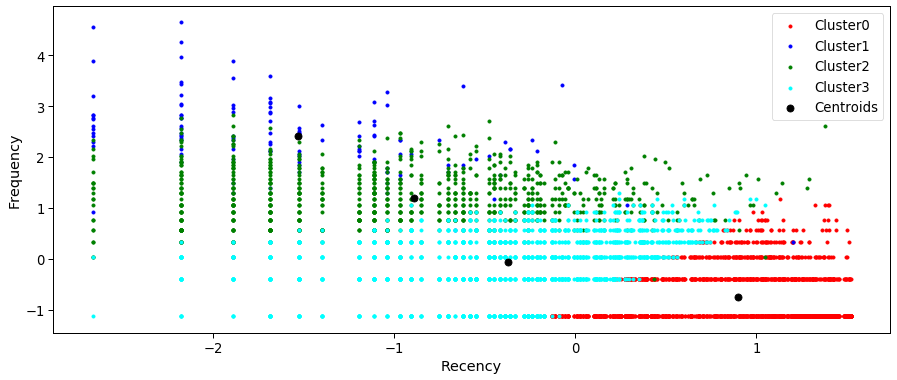

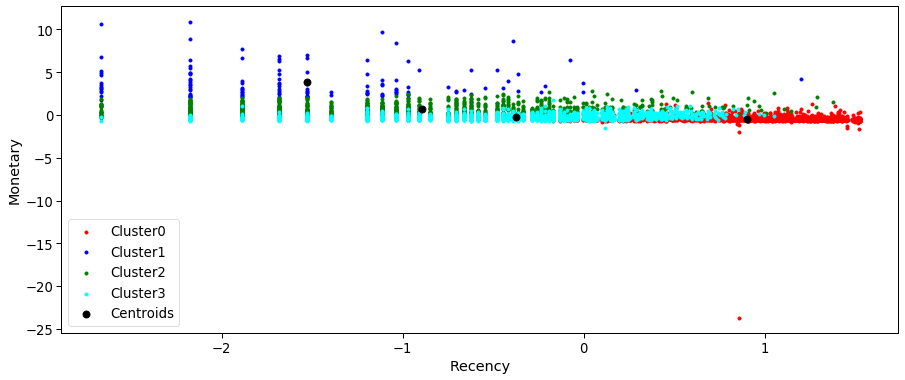

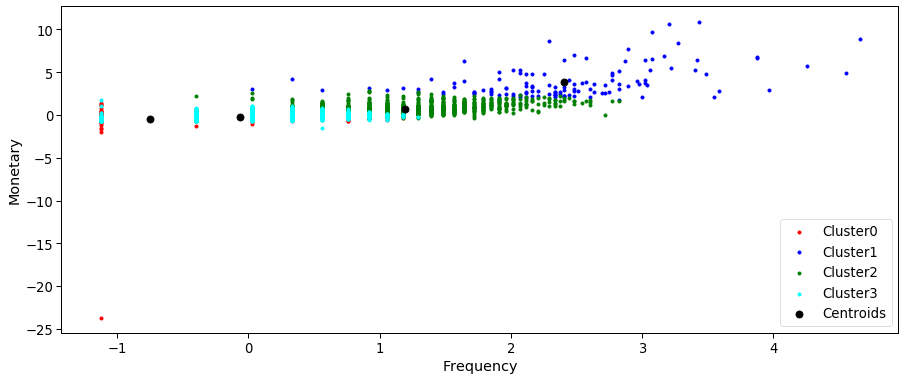

In [94]:
# Plotting two dimesional plots of each attributes respectively.
X = normal_df.iloc[:,0:3].values
count=X.shape[1]
for i in range(0,count):
    for j in range(i+1,count):
        plt.figure(figsize=(15,6));
        plt.scatter(X[cluster_labels == 0, i], X[cluster_labels == 0, j], s = 10, c = 'red', label = 'Cluster0')
        plt.scatter(X[cluster_labels == 1, i], X[cluster_labels == 1, j], s = 10, c = 'blue', label = 'Cluster1')
        plt.scatter(X[cluster_labels == 2, i], X[cluster_labels == 2, j], s = 10, c = 'green', label = 'Cluster2')
        plt.scatter(X[cluster_labels == 3, i], X[cluster_labels == 3, j], s = 10, c = 'cyan', label = 'Cluster3')
        plt.scatter(kmeans.cluster_centers_[:,i], kmeans.cluster_centers_[:,j], s = 50, c = 'black', label = 'Centroids')
        plt.xlabel(normal_df.columns[i])
        plt.ylabel(normal_df.columns[j])
        plt.legend()        
        plt.show();

We can clearly see the different customers segments with the help of scatter plots. Most evidently from the plot of Recency v/s frequency almost each segment is seprate without much overlap.

Now let's check the behaviour of these segments with the help of snake plots.

### Snake plots 

- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Plot each cluster's average normalized values of each attribute

*To plot this we should have normalized data distribution and all the attributes in a single column. We will use pandas melt facility on normal_df to achieve that*

In [95]:
# Assign Cluster values to each customer in normalized dataframe
normal_df = normal_df.assign(Cluster = cluster_labels)

# Melt normalized dataframe into long form to have all metric in same column
normal_melt = pd.melt(normal_df.reset_index(),
                      id_vars=['CustomerID','Cluster'],
                      value_vars=['Recency', 'Frequency', 'Monetary'],
                      var_name='Metric',
                      value_name='Value')
normal_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346,0,Recency,1.43
1,12347,2,Recency,-1.89
2,12348,3,Recency,0.40
3,12349,3,Recency,-0.58
4,12350,0,Recency,1.40


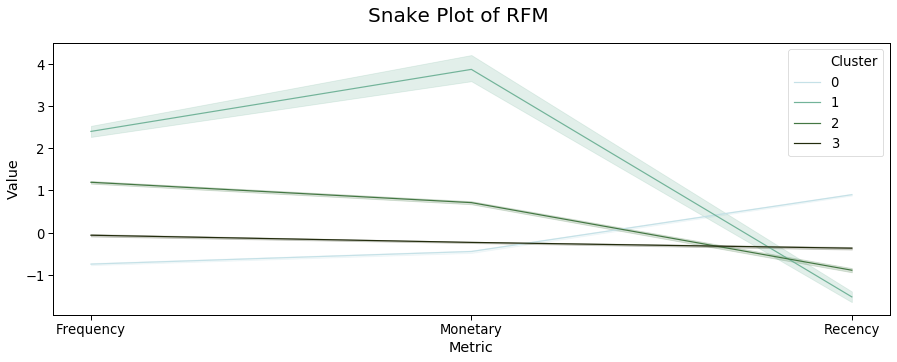

In [96]:
# a snake plot with K-Means
plt.figure(figsize=(15,5))
palette = sns.color_palette("mako_r", 4)
sns.lineplot(x = 'Metric',
             y = 'Value',
             hue = 'Cluster',
             data = normal_melt,
             palette = "ch:4.4,.44")

plt.suptitle("Snake Plot of RFM",fontsize=20)
plt.show();

So the behaviour of customers in different clusters is evident from the above graph:

- Customer in cluster 1 has highest frequency & monetary along with lowest recency value. These are the most valuable customers to the firm
- Customers in cluster 2 also shows similar shopping pattern like cluster 1 but on an average less value for each attributes. These are the loyal customers.
- Customers in cluster 3 shows lower frequency, monetary as well as high recency rates as compared to cluster 2. Some of them are occasional customers who shops during shopping festival. These are more likely to respond to a campaign and has the potential to turn profitable.
- And the customers in cluster 0 shows a totally opposite behaviour as compared to cluster 2 i.e. the highly unprofitable or the lost customers whom we don't need to pay much attention, May be some targeted offers can bring them back to shopping.

### Heat Map

We will utilize heat map to visualize the relative importance of each attributes in all four customer segments i.e. clusters. It calculates importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average). 

The farther a ratio is from 0, the more important that attribute is for a segment relative to the total population.

In [97]:
# Assign Cluster labels to RFM table
rfm_table_cluster = rfm_table.assign(Cluster = cluster_labels)

# Average attributes for each cluster
cluster_avg = rfm_table_cluster.groupby(['Cluster']).mean() 

# Calculate the population average
population_avg = rfm_table.mean()

# Calculate relative importance of attributes by 
relative_imp = cluster_avg / population_avg - 1

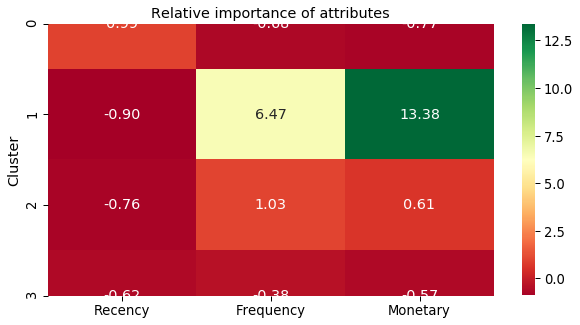

In [98]:
plt.figure(figsize=(10, 5))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();

We can observe below things through above graph:

- Though the Cluster 1 and 2 shows similar pattern of attributes, but all three attributes in Cluster 1 are given more importance relative to Cluster 2.
- Again evident that the cluster 3 which is a segment of potential customers shows an average similar importance to all three attributes as shown in the snake plot.
- In Cluster 0 the all attributes are relatively oppsoite in valuation as compared to cluster 2.